In [576]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Embedding, Flatten, Reshape
from keras.optimizers import Adam

In [577]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    cm = cm.astype("float") / cm.sum(axis=1)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, fontsize=20, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i,j] > 0.5 else "black"        
        plt.text(j, i, format(cm[i, j], ".2f"), horizontalalignment="center", verticalalignment="center", color=color, fontsize=40)

    plt.ylabel("Correction", fontsize=15)
    plt.xlabel("Prédiction", fontsize=15)

<h1>Traitement des données</h1>

In [578]:
# chargement des deux tables
real_news = pd.read_csv("./dataset1/True.csv")
fake_news = pd.read_csv("./dataset1/Fake.csv")

In [579]:
# vrai = 1, faux = 0
real_news["label"] = 1
fake_news["label"] = 0

In [580]:
real_news.sample(5)

,title,text,subject,date,label
11962,Lebanon detains Uber driver suspected of murde...,BEIRUT (Reuters) - A Lebanese taxi driver with...,worldnews,"December 18, 2017",1
5424,U.S. lawmakers want say on any Trump Russia sa...,WASHINGTON (Reuters) - Republican and Democrat...,politicsNews,"February 15, 2017",1
5112,White House spokesman says almost certain Trum...,WASHINGTON (Reuters) - White House spokesman S...,politicsNews,"March 6, 2017",1
19815,North Korea fuel prices soar after U.N. sancti...,(Reuters) - Gasoline and diesel prices rose sh...,worldnews,"September 18, 2017",1
13036,"Lebanon's Hariri rescinds resignation, drawing...",BEIRUT (Reuters) - Lebanese Prime Minister Saa...,worldnews,"December 5, 2017",1


In [581]:
fake_news.sample(5)

,title,text,subject,date,label
150,‘Alt-Right’ White House Reporter Gets Fooled ...,When Donald Trump allowed popular Nazi blog Th...,News,"November 2, 2017",0
20072,#CrookedHillary Uses Twitter To Accuse Trump O...,Hillary Clinton is bending over backwards to c...,left-news,"Aug 25, 2016",0
9623,ESPN’S JEMELE HILL Makes Shocking Admission Ab...,ESPN anchor Jemele Hill says she deserved to b...,politics,"Oct 22, 2017",0
3480,Bombshell CIA Report Reveals Russia’s Secret ...,Russia interfered in the 2016 U.S. presidentia...,News,"December 9, 2016",0
16249,BREAKING: PRESIDENT TRUMP MAKES HIS PICK For T...,JUDGE NEIL GORSUCH A strict conservative sim...,Government News,"Jan 31, 2017",0


In [582]:
# création du dataset complet
dataframe = pd.concat([real_news, fake_news])
dataframe.sample(10)

,title,text,subject,date,label
23244,Ron Paul: Syria Has Been in Chaos Ever Since O...,21st Century Wire says Ron Paul told RT that t...,Middle-east,"September 29, 2016",0
18103,END OF FOX NEWS MONOPOLY? LIBERAL Murdoch Sons...,"The wife of Fox News co-owner James Murdoch, m...",left-news,"Aug 19, 2017",0
13396,"Bolivia's Morales says he'll seek fourth term,...",LA PAZ (Reuters) - Bolivian President Evo Mora...,worldnews,"November 30, 2017",1
16732,UK PM May's meeting with EU officials 'constru...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 23, 2017",1
11296,JUDGE JEANINE ON FIRE: “Paul Ryan Needs to Ste...,,politics,"Mar 25, 2017",0
16436,Iraqi PM Abadi demands Kurds cancel secession ...,BAGHDAD (Reuters) - Iraq s prime minister dema...,worldnews,"October 26, 2017",1
2552,American Intelligence Agents Fear Giving Trum...,Donald Trump is clearly a threat to our nation...,News,"February 13, 2017",0
3134,Trump lawyer says president not informed he is...,WASHINGTON (Reuters) - One of President Donald...,politicsNews,"June 18, 2017",1
15460,"Trump to give major North Korea speech, then p...",SEOUL (Reuters) - President Donald Trump will ...,worldnews,"November 7, 2017",1
5876,NRA Breaks Silence On Orlando By Claiming ‘Po...,As is typical for the NRA whenever there s a h...,News,"June 14, 2016",0


In [583]:
print(f"Nombre de références : {dataframe.title.count()}")
print(f"Nombre de fake news : {fake_news.title.count()}")
print(f"Nombre de vraies news : {real_news.title.count()}")

Nombre de références : 44898
Nombre de fake news : 23481
Nombre de vraies news : 21417


In [584]:
# ici on ne s'intéresse qu'au titre et au label
del dataframe["text"]
del dataframe["subject"]
del dataframe["date"]

In [585]:
dataframe.sample(10)

,title,label
10615,MSNBC’S CHRIS MATTHEWS DEFENDS VA SHOOTER: “He...,0
16855,[VIDEO] DINESH D’SOUZA Warned Us About What Th...,0
9437,WOW! JEB BUSH Claims Roy Moore Should “Step As...,0
12655,VIRAL VIDEO: A Must Watch Video Hillary Doesn’...,0
2099,"Amid Trump backlash, his U.N. envoy says stand...",1
15672,UPDATE: JUDGE REJECTS STATE DEPARTMENT PUSH FO...,0
11073,White House backs Treasury view that Russia's ...,1
6867,This Simple Graph Blows The ‘Media Has A Libe...,0
5376,Top Senate Republican: Will move on healthcare...,1
7369,"Clinton, Obama pledge unity behind Trump presi...",1


In [586]:
# nettoyage des données (ponctuations)

stopWords = set(stopwords.words("english"))

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–"}
    res = text
    if res != None:
        for elm in forbidden:
            res = res.replace(elm, "")
        res = res.split()
        cleaned = []
        for word in res:
            if not word in stopWords:
                cleaned.append(word)
        res = " ".join(cleaned)
    return res

dataframe["title"] = dataframe["title"].apply(cleanText)

dataframe.sample(10)

,title,label
2547,Whoopi SHREDS Betsy DeVos Ignorance Of Public ...,0
9885,North Korea learn Iran nuclear deal US says,1
15561,Catalonias exleader granted freedom campaign i...,1
3377,Trumps clear try rebuild Russia ties Tillerson,1
10096,Former New York deputy secretary state accused...,1
11426,ENVIRONMENTAL TERRORISTS Videotape Themselves ...,0
972,Trump says Manafort charges years ago indictme...,1
14633,Refugee crisis influx boon German integration ...,1
11256,REPORT FBI DIRECTOR COMEY Blocked By Obama Adm...,0
13018,Trump undermining stability Jerusalem move Ger...,1


In [587]:
# on sépare les données en données d'entraînement et données de test (80% et 20%)
x_train, x_test, y_train, y_test = train_test_split(dataframe["title"], dataframe["label"], test_size=0.80, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 8979
Données de test : 35919


In [588]:
max_features = 10000 # taille max du vocab
maxlen = 30 # taille max de séquence

In [589]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [590]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)

In [591]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [592]:
batch_size = 256
nb_epochs = 10
embedded_dim = 100

In [593]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embedded_dim, input_length=maxlen, trainable=True))
model.add(Reshape((1, 30, 100)))
model.add(Conv2D(64, (3, 1), padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 1), padding="same"))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 30, 100)           1000000   
_________________________________________________________________
reshape_21 (Reshape)         (None, 1, 30, 100)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 30, 64)         19264     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 1, 30, 32)         6176      
_________________________________________________________________
flatten_21 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [594]:
progress = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs)

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
8979/8979 [==============================] - 0s 49us/step - loss: 0.6816 - accuracy: 0.7853
Epoch 2/10
8979/8979 [==============================] - 0s 26us/step - loss: 0.6259 - accuracy: 0.8627
Epoch 3/10
8979/8979 [==============================] - 0s 27us/step - loss: 0.4524 - accuracy: 0.8977
Epoch 4/10
8979/8979 [==============================] - 0s 26us/step - loss: 0.2589 - accuracy: 0.9194
Epoch 5/10
8979/8979 [==============================] - 0s 27us/step - loss: 0.1752 - accuracy: 0.9408
Epoch 6/10
8979/8979 [==============================] - 0s 26us/step - loss: 0.1234 - accuracy: 0.9629
Epoch 7/10
8979/8979 [==============================] - 0s 27us/step - loss: 0.0853 - accuracy: 0.9769
Epoch 8/10
8979/8979 [==============================] - 0s 26us/step - loss: 0.0610 - accuracy: 0.9849
Epoch 9/10
8979/8979 [==============================] - 0s 26us/step - loss: 0.0449 - accuracy: 0.9894
Epoch 10/10
8979/8979 [==============================] - 0s 26us/step - l

In [595]:
model.save("firstTry2.h5")

In [596]:
# art plastique du turfu featuring le poto matplotlib
from matplotlib import pyplot as plt

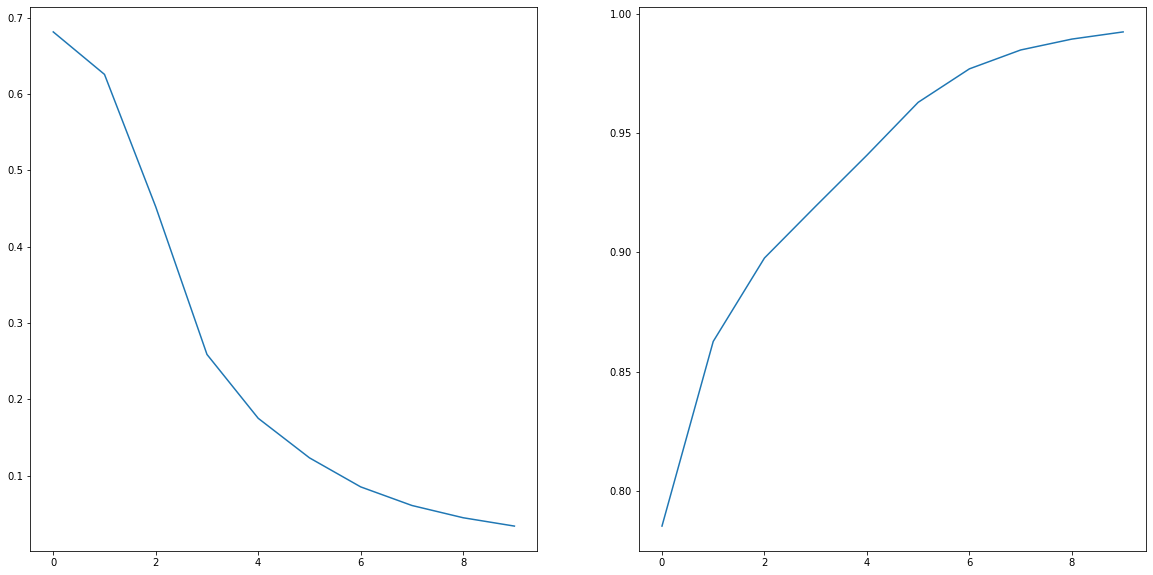

In [597]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(20,10)

ax[0].plot(progress.history["loss"])

ax[1].plot(progress.history["accuracy"])

plt.show()

In [598]:
to_predict = dataframe

In [599]:
X_test = to_predict["title"]
X_test

0        As US budget fight looms Republicans flip fisc...
1        US military accept transgender recruits Monday...
2          Senior US Republican senator Let Mr Mueller job
3        FBI Russia probe helped Australian diplomat ti...
4        Trump wants Postal Service charge much Amazon ...
                               ...                        
23476    McPain John McCain Furious That Iran Treated U...
23477    JUSTICE Yahoo Settles Email Privacy Classactio...
23478    Sunnistan US Allied Safe Zone Plan Take Territ...
23479    How Blow $700 Million Al Jazeera America Final...
23480    10 US Navy Sailors Held Iranian Military Signs...
Name: title, Length: 44898, dtype: object

In [600]:
Y_test = to_predict["label"]
Y_test

0        1
1        1
2        1
3        1
4        1
        ..
23476    0
23477    0
23478    0
23479    0
23480    0
Name: label, Length: 44898, dtype: int64

In [601]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   42,
          5,  273,  171, 1315,   62, 3133, 2662, 8426])

In [602]:
predictions = model.predict(X_test)

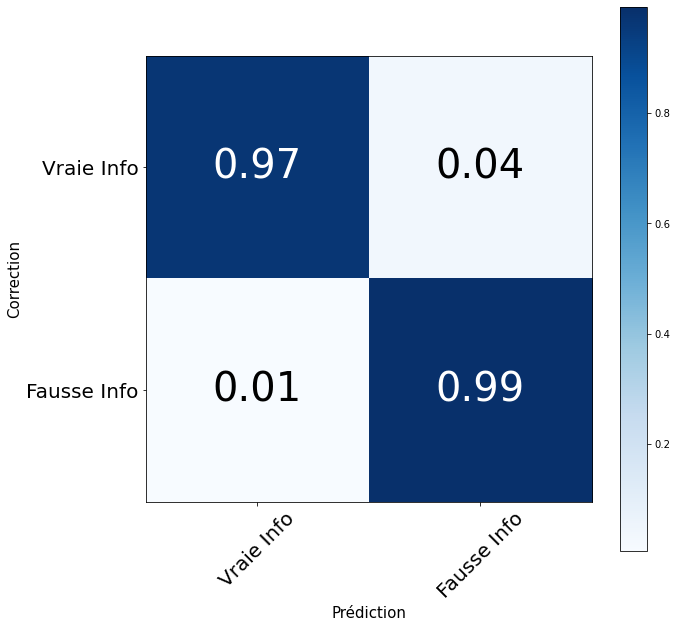

In [603]:
cm_plot_labels = ["Vraie Info","Fausse Info"]
cm = confusion_matrix(Y_test, np.round(predictions))
plot_confusion_matrix(cm, cm_plot_labels)